# 3. Image similarity measures

Juan Berrios | juanberrios@pitt.edu | Last updated: October 28, 2022

**Summary and overview of the data:**

- The purpose of this notebook is to test different measures to measure the degree of similarity between two images using different libraries. I also explore the functions of [OpenCV's](https://pypi.org/project/opencv-python/) Python implementation to facilitate image previewing and editing. "CV" stands for "computer vision". Some tutorials about this tool can be found in [1](https://pythonprogramming.net/loading-images-python-opencv-tutorial/), [2](https://www.geeksforgeeks.org/opencv-python-tutorial/), and [3](https://www.mygreatlearning.com/blog/opencv-tutorial-in-python/).

# 1. Preparations

In [1]:
#Importing libraries

import pandas as pd #for data frames
import numpy as np #for arrays
import cv2 #for images
from matplotlib import pyplot as plt #Used to display images

#Releasing all output:     

from IPython.core.interactiveshell import InteractiveShell #Prints all commands rather than the last one.
InteractiveShell.ast_node_interactivity = "all"

#Turning pretty print off:
%pprint

Pretty printing has been turned OFF


## 2. Exploring images

- The very first thing to do is to load an image. I will start with a sample image of a cat stored in my image directory. We will use `cv2.imread` to load it. This method loads the image as an array with the following format: row (height) x column (width) x color (3). We will use `matplotlib` to display the image (we could also use `cv2.imshow`, which I find more cumbersome as it requires opening a new window which will then have to be closed manually or setting a key/timer).

In [2]:
img = cv2.imread("data/jamboards/cat.jpg",1) #1 stands for an image loaded in color, 1 is also the default

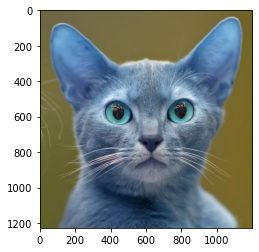

In [3]:
plt.imshow(img)
plt.show()

- As can be seen from the sample above, OpenCV stores the channel in BGR (Blue, Green and Red) order by default, which is why the cat looks blue. We can alter this using the `cvtColor` method, as displayed below. This method is used for conversion between color spaces, of which there are many. More information about this method can be found [here](https://www.geeksforgeeks.org/python-opencv-cv2-cvtcolor-method/).

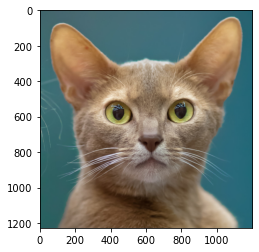

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

- Alternatively, we could load the same image image in grayscale:

In [5]:
img = cv2.imread("data/jamboards/cat.jpg",0)

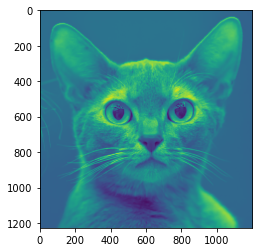

In [6]:
plt.imshow(img)
plt.show()

- We will have to do the same conversion again so that it looks like what we'd expect a black and white image to look like:

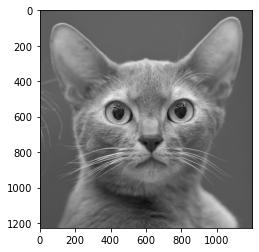

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

- When we are done manipulating the image, we can save directly using `cv2.imwrite`:

In [8]:
cv2.imwrite('data/jamboards/catgray.png',img)

True

### 1.2. Image differences

- An additional need for this project was to detect differences between images and extracting such differences so that they could be visualized (e.g., by superimposing the differences to appreciate divergences). OpenCV happens to have a useful method (`.absdiff`) for this purpose:

In [9]:
#Loading pictures

img1 = cv2.imread("data/jamboards/cat.jpg")            #Original
img2 = cv2.imread("data/jamboards/cat_outline.jpg")    #Cat with an outline
img3 = cv2.imread("data/jamboards/cat_sideways.jpg")   #Sideways cat

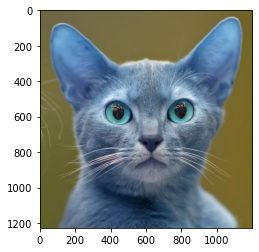

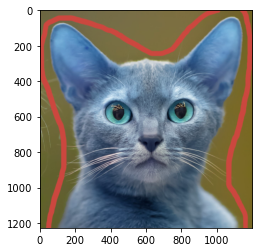

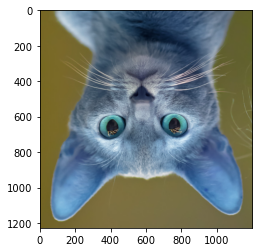

In [10]:
#Previewing images

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

In [11]:
#Turning to grayscale

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

- As per [OpenCV's](https://docs.opencv.org/3.4/d2/de8/group__core__array.html) `.absdiff` "[c]alculates the per-element absolute difference between two arrays or between an array and a scalar." If we do this using the first two images, the result will be an array specifiying whether there is a difference or not (1 or 0) values, to get the overall difference, we can calculate the mean of the array:

In [12]:
#Calculating
diff = cv2.absdiff(img1,img2)

#Examining
type(diff)
diff[:5] #Sampling

<class 'numpy.ndarray'>

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
#Mean difference:

np.mean(diff)

0.711325325732899

- Comparing the three pictures, we can see that this is fairly effective at capturing differences between otherwise similar images, as the sideways picture (img3) has a much higher mean than the picture that only has an added element (img2): 

In [14]:
diff1_1 = cv2.absdiff(img1,img1)
diff1_2 = cv2.absdiff(img1,img2)
diff1_3 = cv2.absdiff(img1,img3)

print("Difference is:", np.mean(diff1_1))
print("Difference is:", np.mean(diff1_2))
print("Difference is:", np.mean(diff1_3))

Difference is: 0.0
Difference is: 0.711325325732899
Difference is: 35.111682953311615


- If need be, we can attempt extracting the differences for manual inspection. This can be done by first creating a grayscale mask using the difference we have already calculated above:

In [15]:
mask = diff

In [16]:
th = 1
imask = mask>1

In [17]:
canvas = np.zeros_like(img2,np.uint8)
canvas[imask] = img2[imask]

- The result will look something like this:

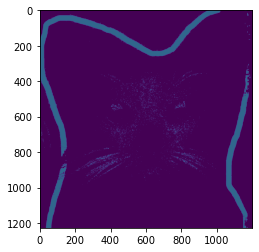

In [18]:
plt.imshow(canvas)
plt.show()

- This is a good, simple approach for images that have very noticeable differences, but it might not as be as effective when difference are more subtle, which migth require more computationally complex measures. For this purpose we'll explore two libraries offering such measures. I'll compare them in terms of accuracy, ease of use, and performance.

## 3. Image similarity measures

- Some tutorials using the tools tested below can be found at [1](https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6), [2](https://betterprogramming.pub/how-to-measure-image-similarities-in-python-12f1cb2b7281), and [3](https://pyimagesearch.com/2014/09/15/python-compare-two-images/). They also have citations that can be used when discussing the metrics. 

### 3.1. Sewar library

- We'll start with the [Sewar library](https://pypi.org/project/sewar/). The documentation can be found [here](https://sewar.readthedocs.io/en/latest/). The metrics that it offers are in the following list. The metrics can be loaded individually. Those currently available: mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb. 
     - Mean Squared Error (MSE)
     - Root Mean Squared Error (RMSE)
     - Peak Signal-to-Noise Ratio (PSNR) 
     - Structural Similarity Index (SSIM) 
     - Universal Quality Image Index (UQI) 
     - Multi-scale Structural Similarity Index (MS-SSIM)
     - Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS) 
     - Spatial Correlation Coefficient (SCC) 
     - Relative Average Spectral Error (RASE) 
     - Spectral Angle Mapper (SAM) 
     - Spectral Distortion Index (D_lambda) 
     - Spatial Distortion Index (D_S) 
     - Quality with No Reference (QNR) 
     - Visual Information Fidelity (VIF) 
     - Block Sensitive - Peak Signal-to-Noise Ratio (PSNR-B) 

In [19]:
#Loading library 

from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb

In [20]:
%%time

#Identical comparison so we can have a baseline of what the measures actually look like

print("MSE: ", mse(img1,img1))
print("RMSE: ", rmse(img1, img1))
print("PSNR: ", psnr(img1, img1))
print("SSIM: ", ssim(img1, img1))
print("UQI: ", uqi(img1, img1))
print("MSSSIM: ", msssim(img1, img1))
print("ERGAS: ", ergas(img1, img1))
print("SCC: ", scc(img1, img1))
print("RASE: ", rase(img1, img1))
print("SAM: ", sam(img1, img1))
print("VIF: ", vifp(img1, img1))

MSE:  0.0
RMSE:  0.0
PSNR:  inf
SSIM:  (1.0, 1.0)
UQI:  1.0
MSSSIM:  (1+0j)
ERGAS:  0.0
SCC:  0.8958557274701412
RASE:  0.0
SAM:  2.1073424255447017e-08
VIF:  0.9999999999690077
Wall time: 33.9 s


- 0 of values close to it indicate perfect similarity in MSE, RMSE, ERGAS, and RASE. Values close to 1 do likewise for SSIM, UQI, MSSSSIM, SCC, and VIF.

In [21]:
%%time

#Comparison between images with a small similarity

print("MSE: ", mse(img1,img2))
print("RMSE: ", rmse(img1, img2))
print("PSNR: ", psnr(img1, img2))
print("SSIM: ", ssim(img1, img2))
print("UQI: ", uqi(img1, img2))
print("MSSSIM: ", msssim(img1, img2))
print("ERGAS: ", ergas(img1, img2))
print("SCC: ", scc(img1, img2))
print("RASE: ", rase(img1, img2))
print("SAM: ", sam(img1, img2))
print("VIF: ", vifp(img1, img2))

MSE:  7.102427388707926
RMSE:  2.6650379713444847
PSNR:  39.61673558436987
SSIM:  (0.989320759012373, 0.989627050750917)
UQI:  0.9992131628576087
MSSSIM:  (0.9831668037407651+0j)
ERGAS:  236.52224811003472
SCC:  0.7568262641679122
RASE:  59.13056202750868
SAM:  0.022666034338841814
VIF:  0.9666093817238499
Wall time: 34.2 s


In [22]:
%%time 

#Comparison between images with a smaller similarity

print("MSE: ", mse(img1,img3))
print("RMSE: ", rmse(img1, img3))
print("PSNR: ", psnr(img1, img3))
print("SSIM: ", ssim(img1, img3))
print("UQI: ", uqi(img1, img3))
print("MSSSIM: ", msssim(img1, img3))
print("ERGAS: ", ergas(img1, img3))
print("SCC: ", scc(img1, img3))
print("RASE: ", rase(img1, img3))
print("SAM: ", sam(img1, img3))
print("VIF: ", vifp(img1, img3))

MSE:  2171.753075461455
RMSE:  46.60207157907742
PSNR:  14.762699156696508
SSIM:  (0.5413131921995422, 0.5769837062570526)
UQI:  0.870998194328189
MSSSIM:  (0.39063196652426735+0j)
ERGAS:  9329.391834407814
SCC:  -0.005756366873270919
RASE:  2332.3479586019535
SAM:  0.4030118584697724
VIF:  0.0253689073899093
Wall time: 33.4 s


- **More difference, higher value:** MSE, RMSE, PSNR, ERGAS, RASE, SAM
- **More difference, smaller value:** SSIM (an average), UQI, MSSIM, SCC, SAM, VIF 
- It took around a minute for all comparisons to run. They all ran smoothly. 

### 3.2. Image_similarity_measures library

- A similar [library](https://pypi.org/project/image-similarity-measures/) with a self-explanatory title. It implements a total of eight metrics, as listed below. 
    - Root mean square error (RMSE)
    - Peak signal-to-noise ratio (PSNR)
    - Structural Similarity Index (SSIM)
    - Feature-based similarity index (FSIM)
    - Information theoretic-based Statistic Similarity Measure (ISSM)
    - Signal to reconstruction error ratio (SRE)
    - Spectral angle mapper (SAM)
    - Universal image quality index (UIQ)

In [41]:
from image_similarity_measures.quality_metrics import rmse, psnr, ssim, fsim, issm, sre, sam, uiq

In [42]:
%%time

#Comparison between images with a small similarity

print("RMSE: ", rmse(img1,img2))
print("PSNR: ", psnr(img1,img2))
print("SSIM: ", ssim(img1, img2))
print("SRE: ", sre(img1, img2))
print("SAM: ", sam(img1, img2))

IndexError: tuple index out of range

In [25]:
%%time

#Comparison between images with a smaller similarity

print("RMSE: ", rmse(img1,img3))
print("PSNR: ", psnr(img1,img3))
print("SSIM: ", ssim(img1, img3))
print("SRE: ", sre(img1, img3))
print("SAM: ", sam(img1, img3))

IndexError: tuple index out of range

- By comparison, this library ran into issues when using certain measures (FSIM, ISSM, UIQ). The comparisons took longer to complete, and the measures appear to be using some kind of normalization. It is, however, als capturing differences. The metrics are the same other than SRE, which lower if the images are more difference. 

### 3.3. Skimage

- Lastly we have [skimage](https://scikit-image.org/), realted to [scitkit-learn](https://scikit-learn.org/stable/) a popular maching learning in Python that offers the advantage of being incorporated into some Python distributions already. It can also interact with OpenCV. It offers the following metrics:
    - skimage.metrics.adapted_rand_error([…])
        - Compute Adapted Rand error as defined by the SNEMI3D contest.
    - skimage.metrics.contingency_table(im_true, …)
        - Return the contingency table for all regions in matched segmentations.
    - skimage.metrics.hausdorff_distance(image0, …)
        - Calculate the Hausdorff distance between nonzero elements of given images.
    - skimage.metrics.hausdorff_pair(image0, image1)
        - Returns pair of points that are Hausdorff distance apart between nonzero elements of given images.
    - skimage.metrics.mean_squared_error(image0, …)
        - Compute the mean-squared error between two images.
    - skimage.metrics.normalized_mutual_information(…)
        - Compute the normalized mutual information (NMI).
    - skimage.metrics.normalized_root_mse(…[, …])
        - Compute the normalized root mean-squared error (NRMSE) between two images.
    - skimage.metrics.peak_signal_noise_ratio(…)
        - Compute the peak signal to noise ratio (PSNR) for an image.
    - skimage.metrics.structural_similarity(im1, …)
        - Compute the mean structural similarity index between two images.
    - skimage.metrics.variation_of_information([…])
        - Return symmetric conditional entropies associated with the VI.

In [26]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import variation_of_information as vif

In [27]:
%%time

print("MSE: ", mse(img1, img2))
print("NRMSE: ", nrmse(img1, img2))
print("SSIM: ", ssim(img1, img2))
print("NMI: ", nmi(img1, img2))
print("PSNR: ", psnr(img1, img2))
print("VIF: ", vif(img1, img2))

MSE:  7.102427388707926
NRMSE:  0.022891431604217194
SSIM:  0.9925449754869581
NMI:  1.7829544808422735
PSNR:  39.61673558436987
VIF:  [1.08500066 1.12436816]
Wall time: 783 ms


In [28]:
%%time

print("MSE: ", mse(img1, img3))
print("NRMSE: ", nrmse(img1, img3))
print("SSIM: ", ssim(img1, img3))
print("NMI: ", nmi(img1, img3))
print("PSNR: ", psnr(img1, img3))
print("VIF: ", vif(img1, img3))

MSE:  2171.753075461455
NRMSE:  0.40029003175106764
SSIM:  0.6213677140086775
NMI:  1.0349738631871752
PSNR:  14.762699156696508
VIF:  [6.30326898 6.30326898]
Wall time: 872 ms


- This appears to be the easiest implementation, and also the one most likely to be familiar to other researchers, so we'll use this for comparisons with the map task data.

### 3.4. Choosing which measures to use

- Going beyond the values, some of the measures might not necessarily be suitable to measure similarity (or even if they are adequate, they might not be widely used). To fullfill those two criteria we will be using primarily SSIM, MSE (squared), and PSNR. As recommended in references [[1]](https://pyimagesearch.com/2014/09/15/python-compare-two-images/)[[2]](https://ieeexplore.ieee.org/document/1284395)[[3]](https://link.springer.com/article/10.1007/s10043-009-0119-z)[[4]](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html#sphx-glr-auto-examples-transform-plot-ssim-py), MSE is simple but can miss important differences. SSIM is a good gauge for structural similarity. PSNR could also be a suitable alternative in some cases. Given that the comparison being made here is between routes (which are isolated from the background), all three can be informative.

## 4. Testing with map data

In [34]:
#Loading sample routes

img1 = cv2.imread("data/jamboards/A1.png")      #Completed by a participant
img2 = cv2.imread("data/jamboards/A1_user.png")    #Completed by a participant
img3 = cv2.imread("data/jamboards/A1_random.png")    #Randomly generated line to serve as a baseline

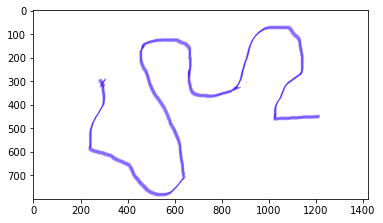

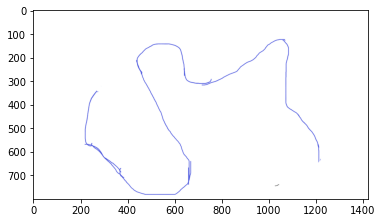

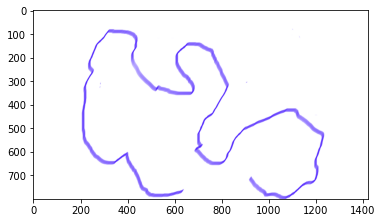

In [35]:
#Previewing

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

- As can be seen in the previews, the routes have been isolated from the maps so that we focus on what is actually different. We will now compare using the metrics explored in the prior section:

In [36]:
#Converting to grayscale

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

In [37]:
#Calculating difference

diff = cv2.absdiff(img1,img1)
print("Difference is:", np.mean(diff))
diff = cv2.absdiff(img1,img2)
print("Difference is:", np.mean(diff))
diff = cv2.absdiff(img1,img3)
print("Difference is:", np.mean(diff))

Difference is: 0.0
Difference is: 4.518515295358649
Difference is: 6.860167897327708


In [38]:
#Similarity metrics

print("ssim: ", ssim(img1, img2))
print("ssim: ", ssim(img1, img3))
print("mse: ", mse(img1, img2))
print("mse: ", mse(img1, img3))
print("nrmse: ", nrmse(img1, img2))
print("nrmse: ", nrmse(img1, img3))
print("psnr: ", psnr(img1, img2))
print("psnr: ", psnr(img1, img3))

ssim:  0.9288259816208075
ssim:  0.9058566121917592
mse:  494.49790523909985
mse:  721.7899129746835
nrmse:  0.08818616449080988
nrmse:  0.1065426832664581
psnr:  21.189159046617632
psnr:  19.546695523741867
